# Jupiter XIIe Lustrum - Text Analytics

# Inleiding

Verloop van brief, mail, whatsapp 

In 2009 x mails
Nu x

2 whatsapp groepen: Jupiter, Members 

Oude manier van varia en de nieuwe Data-driven. 

Wat kunnen we leren over Dispuut Jupiter door middel van het toepassen van text analytics pp whatsapp gesprekshistoriey. 

## Data collectie 
2013
25k berichten 
X mensen 

## Data exploratie 
Aantal pp histogram 
Dagen en uren week plus interpretatie 
Message lengte gemiddeld 
Word cloud pp. 

emoticon sukkel

media koning, voorbeeldplaatje max

## Modeling (wellicht)
Clustering voor types berichten. 

## Conclusie 
Turbulente tijd, eerst waren varia dat wat jij wilde was, nu wat de data zegt. Dat kan wellicht onprettige feiten blootleggen, of minder spannend zijn dan je dacht. Maar met een beter inzicht in het ware communicatie gedrag kunnen we betere chat keuzes maken in de toekomst. 

Heel bewust met data berichten schrijven 
Heel bewust met data betekenis simuleren 
Het Jupiter Data Science Genootschap

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import pandas as pd
import datetime as dt

import nltk
from nltk.probability import FreqDist

import sys
import codecs
import nltk
from nltk.corpus import stopwords

import random
import matplotlib as mpl

from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS


In [15]:
# Import data Simon since 2013
df = pd.read_table('./data_2013.txt', names=["all"])
#df = pd.read_table('./data_2014.txt', names=["all"]

# Extract date from messages with regex
df['date'] = df['all'].str.extract("(\d{1,2}/\d{1,2}/\d{2}, \d{2}:\d{2})", expand=True)

# Parse date as datetime. format: 3/25/13, 14:20
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y, %H:%M')

# Extract name and message
df['name'] = df['all'].str.extract("(\d{1,2}/\d{1,2}/\d{2}, \d{2}:\d{2})( -.*?:)(.*)", expand=True)[1].str[3:-1]
df['message'] = df['all'].str.extract("(\d{1,2}/\d{1,2}/\d{2}, \d{2}:\d{2})( -.*?:)(.*)", expand=True)[2].str.lower()
#df = df.drop('all', 1)

# Include weekday name and hour of day
df['weekday'] = df['date'].dt.weekday_name
df['dayhour'] = df['date'].dt.hour

# Drop missing data 
df = df.dropna()

#Tokenize words
df["tokenized_mess"] = df["message"].apply(nltk.word_tokenize)
df['mess_length'] = df.apply(lambda row: len(row['tokenized_mess']), axis=1)

# Set datatypes
df[['mess_length', 'dayhour']] = df[['mess_length', 'dayhour']].astype(int)
df['weekday'] = df['weekday'].astype('category')

In [16]:
import qgrid

# Just run the below command once
# qgrid.nbinstall(overwrite=True) 

qgrid.show_grid(df.head(1000))

In [26]:
df['emo_cnt'] = df['message'].str.encode('utf-8').str.count(b"(\xf0\x9f)")
df['rups_cnt'] = df['message'].str.encode('utf-8').str.count(b"(\xf0\x9f\x90\x9b)")
df['loser_cnt'] = df['message'].str.encode('utf-8').str.count(b"(\xf0\x9f\x98\x9c)")
df['sukkel_cnt'] = df['message'].str.encode('utf-8').str.count(b"(sukkel)")
df['link_cnt'] = df['message'].str.encode('utf-8').str.count(b"(dumpert)")

In [27]:
def nr_message_plot(df, groupby_col):
    df.groupby(groupby_col).size().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Nr. of messages whole group")
    
def total_emo_cnt(df, col, title):
    df.groupby('name')[col].sum().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title=title)

def name_nr_message_plot(df, name, groupby_col):
    df[df['name'] == name].groupby(groupby_col).size().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Nr. of messages %s" % name)

def message_length_plot(df):
    df.groupby('name')['mess_length'].mean().sort_values(ascending=False).\
    plot.bar(alpha=0.5, title="Average message length")
    
def name_message_length_plot(df, name, groupby_col):
    df[df['name'] == name].groupby('dayhour')['mess_length'].mean().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Average message length %s" % name)    

In [28]:
def name_wordcloud(df, name, verneuk):
    # Join the messages per name 
    if name == 'all':
        dfn = df.groupby(['name'])['message'].apply(lambda x: ','.join(x)).reset_index()
        text = str(dfn['message'].values)
    else:
        dfn = df.groupby(['name'])['message'].apply(lambda x: ','.join(x)).reset_index()
        text = str(dfn.loc[(dfn['name'] == name),'message'].values).lower()
    
    # Verneuk-parameter 
    text = text + (verneuk + ', ')*40
    
    # NLTK's default Dutch stopwords
    default_stopwords = set(nltk.corpus.stopwords.words('dutch'))

    # We're adding some on our own - could be done inline like this...
    custom_stopwords = set((u'omitted', u'media', u'wel', u'even', u'we', u'haha', \
                           u'mee', u'lunch', u'half', u'koffie', u'hoe', u'laat', u'jullie', u'prima'))
    # ... but let's read them from a file instead (one stopword per line, UTF-8)
    #stopwords_file = './stopwords.txt'
    #custom_stopwords = set(codecs.open(stopwords_file, 'r', 'utf-8').read().splitlines())

    all_stopwords = default_stopwords | custom_stopwords

    words = nltk.tokenize.word_tokenize(text)

    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Stemming words seems to make matters worse, disabled
    # stemmer = nltk.stem.snowball.SnowballStemmer('german')
    # words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]

    # Calculate frequency distribution
    fdist = nltk.FreqDist(words)

    # Output top 50 words
    #     for word, frequency in fdist.most_common(50):
    #         print(u'{};{}'.format(word, frequency))
    
    # Initialize wordcloud parameters
    limit = 1000
    bgcolor = '#000000'
    fontcolor='#fafafa'
    
    # Generate wordcloud
    wordcloud = WordCloud(
    max_words=limit,
    stopwords=all_stopwords,
    background_color=bgcolor
    ).generate(text)
    
    # Plot wordcloud
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(6)

    plt.imshow(wordcloud.recolor(color_func=grey_color,  random_state=3))

    plt.title("dikke lul", color=fontcolor, size=30, y=1.01)
    plt.axis('off')
    plt.show()

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

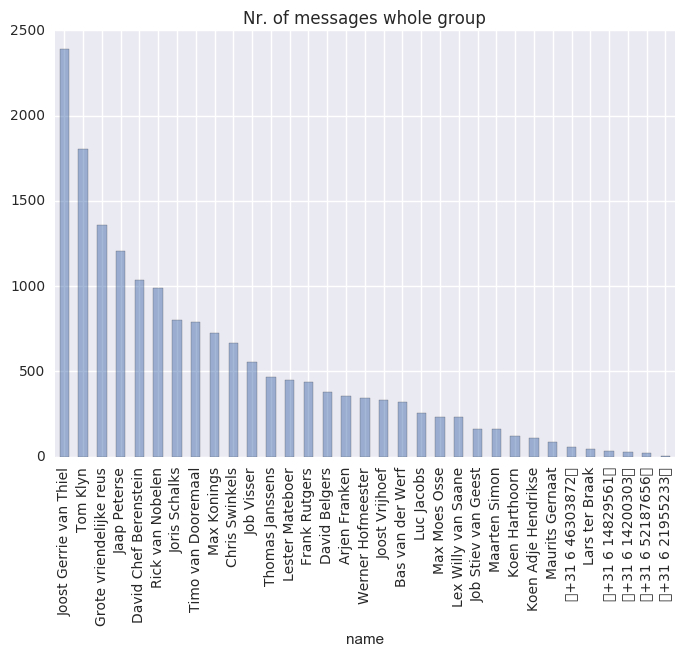

In [130]:
nr_message_plot(df, 'name')

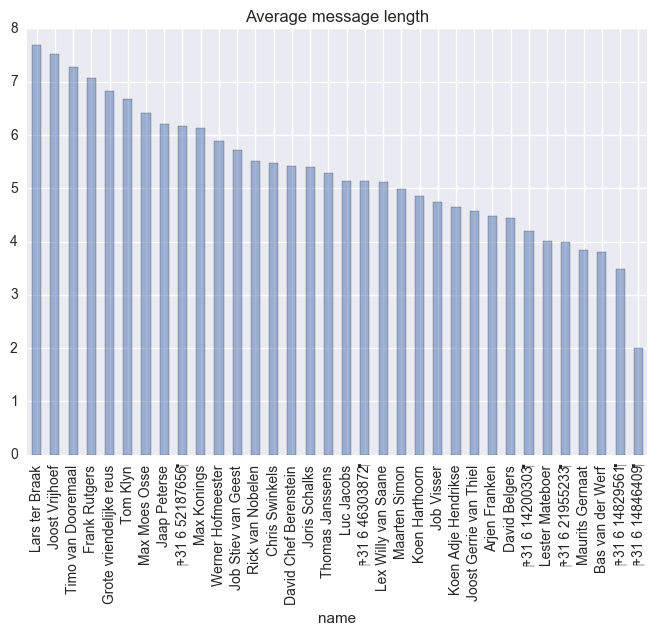

In [38]:
message_length_plot(df)

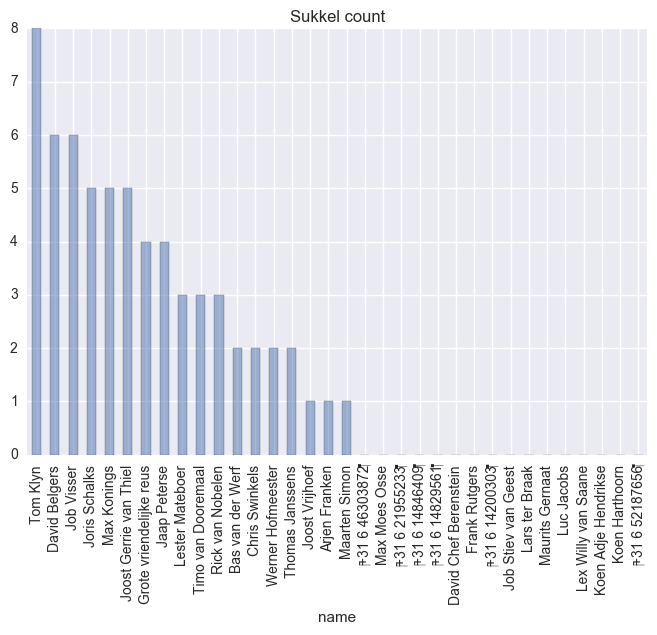

In [29]:
total_emo_cnt(df, 'sukkel_cnt', title = "Sukkel count")

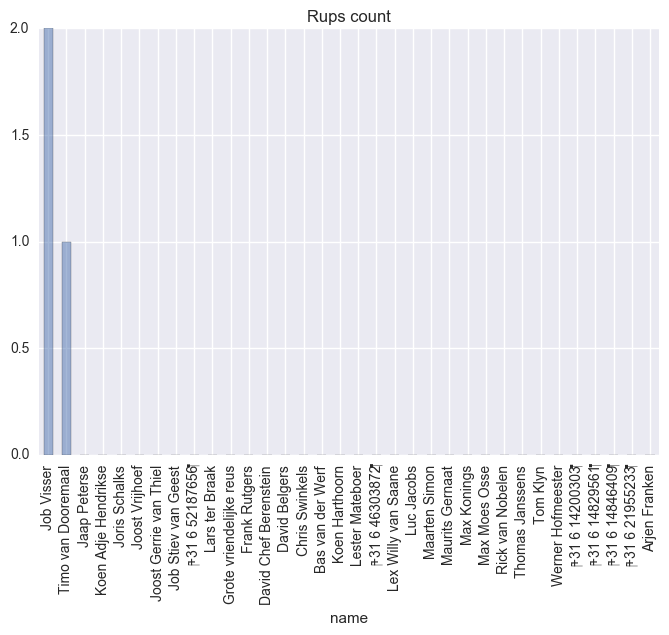

In [37]:
total_emo_cnt(df, 'rups_cnt', title = "Rups count")

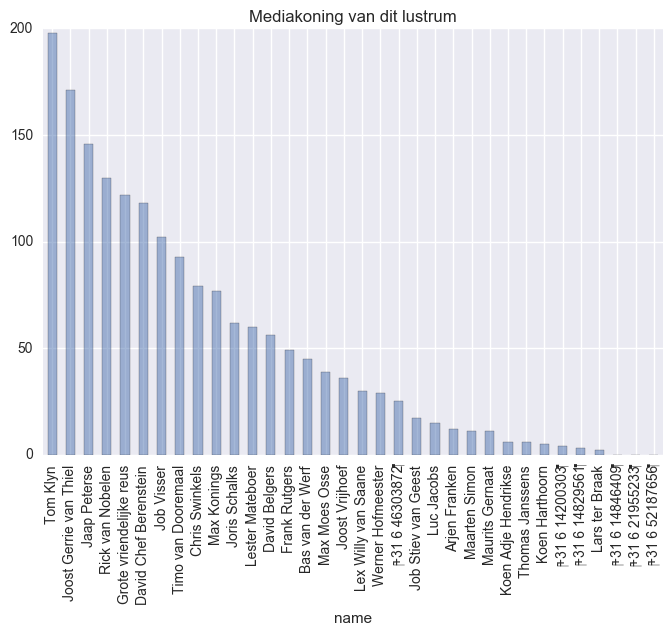

In [31]:
df['media_cnt'] = df['message'].str.count("<media omitted>")
df.groupby('name')['media_cnt'].sum().sort_values(ascending=False).plot.bar(alpha=0.5, title="Mediakoning van dit lustrum")


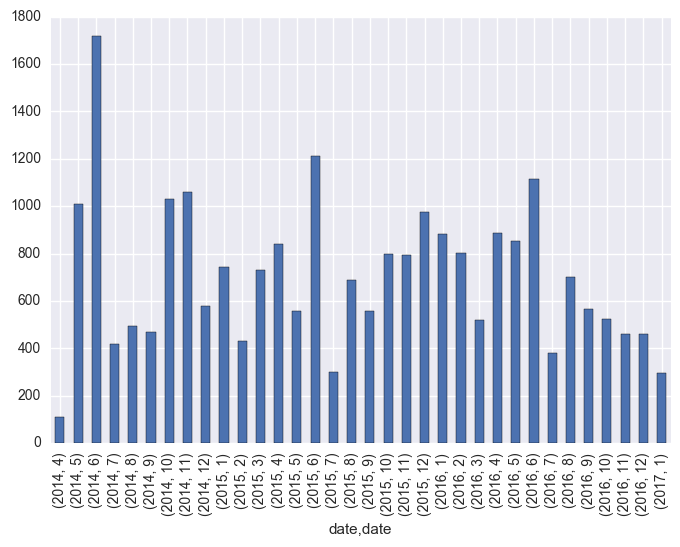

In [72]:
df['message'].groupby([df.date.dt.year, df.date.dt.month]).count().plot(kind="bar")


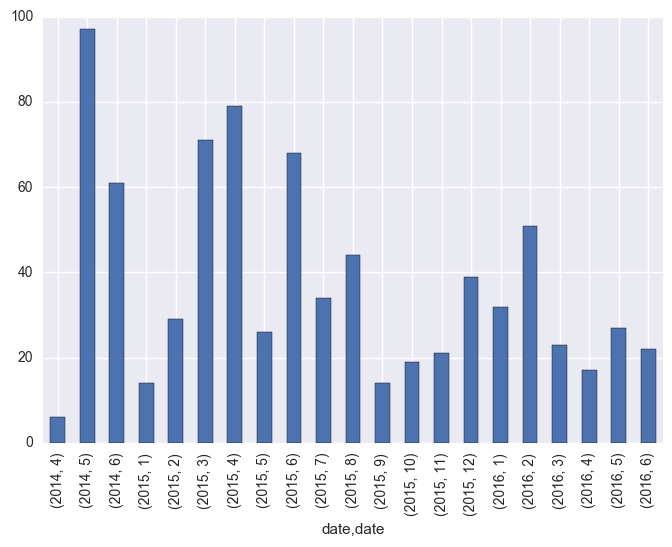

In [69]:
df[df['name'] == 'Job Visser']['message'].groupby([df.date.dt.year, df.date.dt.month]).count().plot(kind="bar")


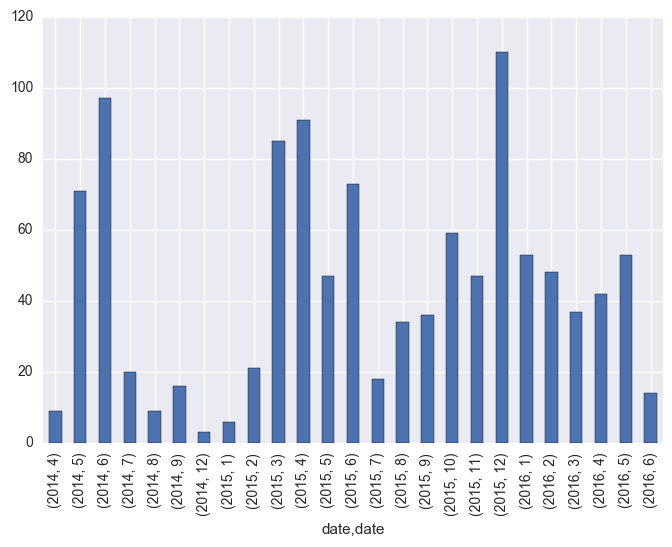

In [71]:
df[df['name'] == 'Timo van Dooremaal']['message'].groupby([df.date.dt.year, df.date.dt.month]).count().plot(kind="bar")


In [262]:
s = "ik vind 😍  😘 matig erg, maar 😂   😜 heel kut en 👍🏽 mag of 💩, rups 🐛 "
s.encode('utf-8')

b'ik vind \xf0\x9f\x98\x8d  \xf0\x9f\x98\x98 matig erg, maar \xf0\x9f\x98\x82   \xf0\x9f\x98\x9c heel kut en \xf0\x9f\x91\x8d\xf0\x9f\x8f\xbd mag of \xf0\x9f\x92\xa9, rups \xf0\x9f\x90\x9b '

In [23]:
df.groupby('name')['loser_cnt'].sum().sort_values(ascending=False)

name
Joris Schalks              3
Max Moes Osse              2
Joost Gerrie van Thiel     1
‪+31 6 52187656‬           0
Job Stiev van Geest        0
Koen Adje Hendrikse        0
Joost Vrijhoef             0
Job Visser                 0
Jaap Peterse               0
Lars ter Braak             0
Grote vriendelijke reus    0
Frank Rutgers              0
David Chef Berenstein      0
David Belgers              0
Chris Swinkels             0
Bas van der Werf           0
Koen Harthoorn             0
Lester Mateboer            0
‪+31 6 46303872‬           0
Lex Willy van Saane        0
Luc Jacobs                 0
Maarten Simon              0
Maurits Gernaat            0
Max Konings                0
Rick van Nobelen           0
Thomas Janssens            0
Timo van Dooremaal         0
Tom Klyn                   0
Werner Hofmeester          0
‪+31 6 14200303‬           0
‪+31 6 14829561‬           0
‪+31 6 14846409‬           0
‪+31 6 21955233‬           0
Arjen Franken              0
Name: los

In [30]:
df[(df['link_cnt'] > 0)]
#df[(df['link_cnt'] > 0) & (df['name'] == 'David Chef Berenstein ')]

,all,date,name,message,weekday,dayhour,tokenized_mess,mess_length,emo_cnt,rups_cnt,loser_cnt,sukkel_cnt,link_cnt
3765,"8/25/14, 21:19 - ‪+31 6 46303872‬: Als iemand ...",2014-08-25 21:19:00,‪+31 6 46303872‬,als iemand de link van het hele filmpje wil: ...,Monday,21,"[als, iemand, de, link, van, het, hele, filmpj...",13,0,0,0,0,1
7967,"2/16/15, 11:08 - Max Konings: Is dit dreas op ...",2015-02-16 11:08:00,Max Konings,is dit dreas op dumpert?,Monday,11,"[is, dit, dreas, op, dumpert, ?]",6,0,0,0,0,1
7968,"2/16/15, 11:10 - Frank Rutgers: http://www.dum...",2015-02-16 11:10:00,Frank Rutgers,http://www.dumpert.nl/mediabase/6639977/705cf...,Monday,11,"[http, :, //www.dumpert.nl/mediabase/6639977/7...",3,0,0,0,0,1
8885,"3/31/15, 17:30 - Rick van Nobelen: Dumpert: Pe...",2015-03-31 17:30:00,Rick van Nobelen,dumpert: pech voor de vrouwenboot... - http:/...,Tuesday,17,"[dumpert, :, pech, voor, de, vrouwenboot, ...,...",13,0,0,0,0,2
13085,"10/1/15, 15:31 - Rick van Nobelen: http://www....",2015-10-01 15:31:00,Rick van Nobelen,http://www.dumpert.nl/mediabase/6685908/0ea40...,Thursday,15,"[http, :, //www.dumpert.nl/mediabase/6685908/0...",3,0,0,0,0,1
13563,"10/23/15, 13:16 - Joost Gerrie van Thiel: Mooi...",2015-10-23 13:16:00,Joost Gerrie van Thiel,mooi op dumpert knallem,Friday,13,"[mooi, op, dumpert, knallem]",4,0,0,0,0,1
20445,"6/21/16, 16:35 - Max Konings: Je bent alleen m...",2016-06-21 16:35:00,Max Konings,je bent alleen maar dumpert filmpjes aan het ...,Tuesday,16,"[je, bent, alleen, maar, dumpert, filmpjes, aa...",9,0,0,0,0,1
20754,"6/30/16, 12:28 - Chris Swinkels: http://www.du...",2016-06-30 12:28:00,Chris Swinkels,http://www.dumpert.nl/mediabase/6821769/4c80c...,Thursday,12,"[http, :, //www.dumpert.nl/mediabase/6821769/4...",3,0,0,0,0,1


In [124]:
df.groupby('name').size().\
    sort_values(ascending=False)[2]

1356

In [21]:
total_emo_cnt(df, '')

TypeError: total_emo_cnt() missing 2 required positional arguments: 'col' and 'title'

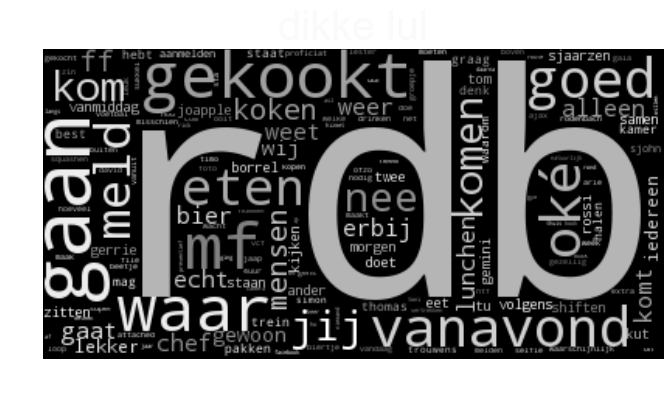

In [32]:
name_wordcloud(df, 'Max Konings', verneuk="")

In [33]:
df['name'].unique()

names = ['Job Visser', 'Tom Klyn', 'Timo van Dooremaal',
       'Luc Jacobs', 'Frank Rutgers', 'David Belgers', 'Thomas Janssens',
       'Joost Vrijhoef', 'David Chef Berenstein',
       'Grote vriendelijke reus', 'Joost Gerrie van Thiel',
       'Werner Hofmeester', 'Joris Schalks',
       'Max Konings', 'Arjen Franken', 'Max Moes Osse', 'Rick van Nobelen',
       'Jaap Peterse', 'Lester Mateboer', 'Chris Swinkels']

name_x = names[:5]  
# Create groups per year

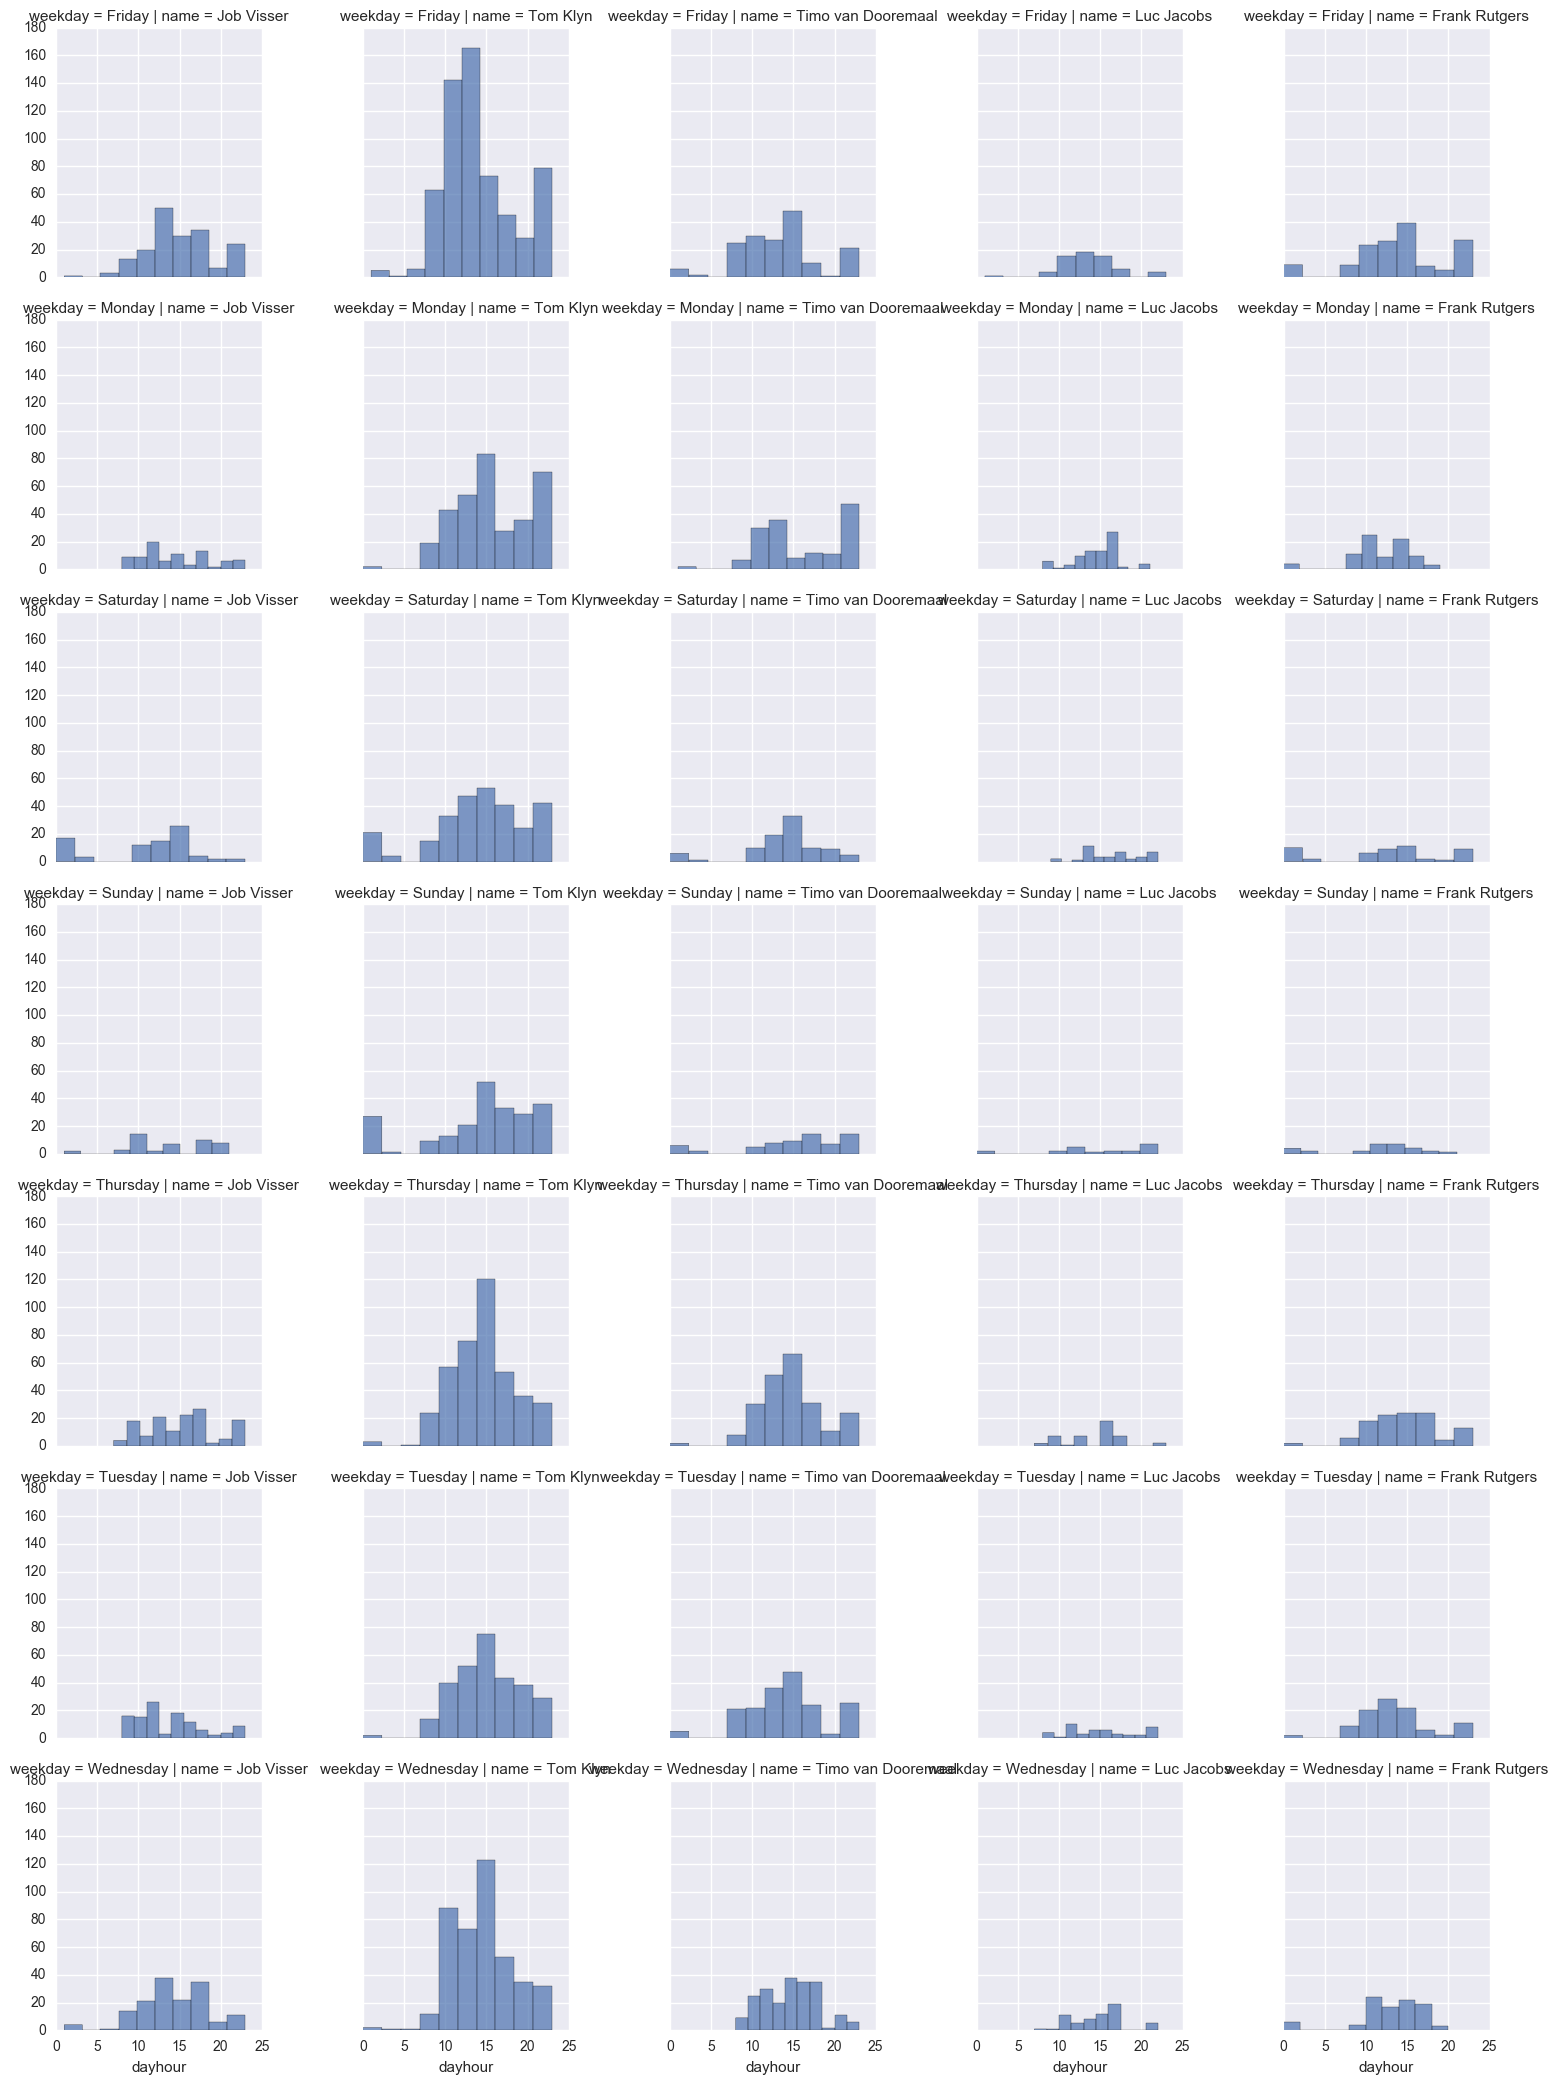

In [34]:
g = sns.FacetGrid(df[df['name'].isin(names[:5])], row="weekday", col="name")
g.map(plt.hist , "dayhour", alpha=.7)
g.add_legend();

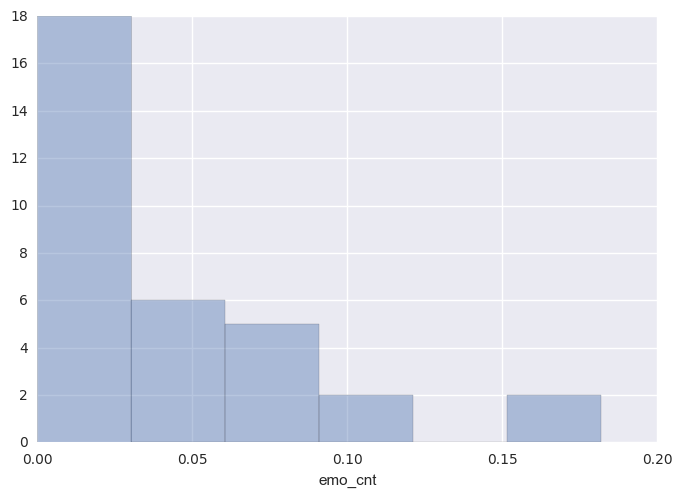

In [244]:
sns.set(color_codes=True)

sns.distplot(df.groupby('name').mean()["emo_cnt"], kde=False, rug=False);

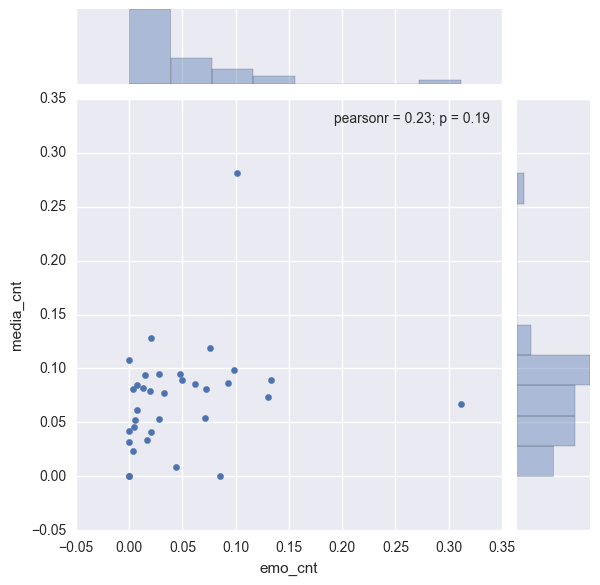

In [35]:
sns.jointplot("emo_cnt", "media_cnt", data=df.groupby('name').mean());


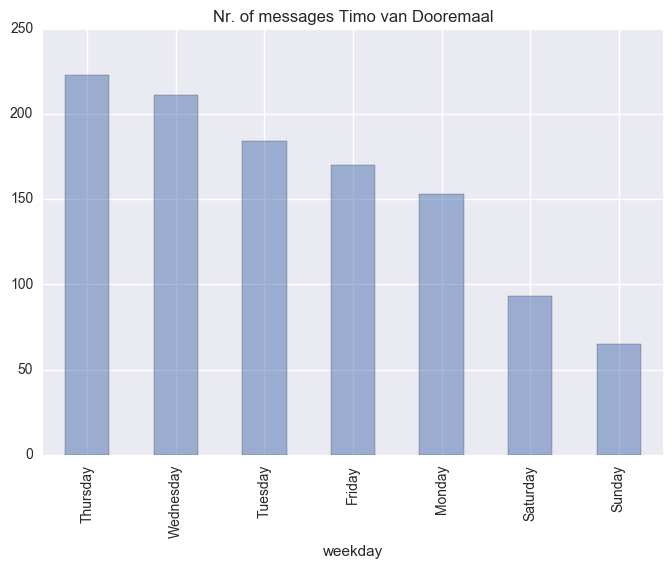

In [36]:
name_nr_message_plot(df, 'Timo van Dooremaal', 'weekday')